In [61]:
! lamin load scprint

Exception ignored in: <function _releaseLock at 0x7ff2bfa68310>
Traceback (most recent call last):
  File "/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/logging/__init__.py", line 228, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


💡 found cached instance metadata: /home/ml4ig1/.lamin/instance--jkobject--scprint.env
💡 loaded instance: jkobject/scprint


In [5]:
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks import ModelCheckpoint, StochasticWeightAveraging, EarlyStopping, LearningRateMonitor, LearningRateFinder

seed_everything(42, workers=True)

from scprint import scPrint
from scprint.trainer import TrainingMode
from scdataloader import DataModule
import pandas as pd
from scdataloader.utils import load_genes

import torch
torch.set_float32_matmul_precision('medium')

%load_ext autoreload
%autoreload 2

Global seed set to 42


In [6]:
# TODO: drop tissue & dev stage until part or is taken in account

hierarchical_labels = [
    "cell_type_ontology_term_id", #1
    # "tissue_ontology_term_id",
    "disease_ontology_term_id", # 2
#    "development_stage_ontology_term_id",
    "assay_ontology_term_id", #3
    'self_reported_ethnicity_ontology_term_id', #4
]
labels_to_pred = hierarchical_labels+[
    'sex_ontology_term_id', #5
    "organism_ontology_term_id", #6
]
all_labels = labels_to_pred+[
    #'dataset_id',
    'cell_culture',
    "heat_diff",
    "total_counts",
    "nnz",
    "dpt_group",
]

gene_emb = '../data/temp/embeddings.parquet'
d_model=256

In [7]:
datamodule = DataModule(
    collection_name="preprocessed dataset",
    gene_embeddings=gene_emb,
    all_labels=all_labels,
    hierarchical_labels=hierarchical_labels,
    organisms=["NCBITaxon:9606"],
    how="random expr",
    max_len=1200,
    add_zero_genes=0,
    # how much more you will see the most present vs less present category 
    weight_scaler=10,
    label_to_weight=labels_to_pred,
    label_to_pred=labels_to_pred,
    batch_size=64,
    num_workers=16,
    train_oversampling=2,
    validation_split=0.05,
    do_gene_pos='../data/main/biomart.parquet',
    test_split=0.05)
testfiles = datamodule.setup()

won't do any check but we recommend to have your dataset coming from local storage

83.14606741573034% are aligned
total dataset size is 97.032938749 Gb
---
dataset contains:
     4926521 cells
     70116 genes
     11 labels
     6 clss_to_pred
     4 hierarchical_clss
     4 join_vars
     1 organisms
dataset contains 229 classes to predict

seeing a string: loading gene positions as biomart parquet file
these files will be considered test datasets:
    /home/ml4ig1/scprint/.lamindb/BljRloq1xjcxRNDpejzI.h5ad
    /home/ml4ig1/scprint/.lamindb/yBCKp6HmXuHa0cZptMo7.h5ad
perc test:  0.0057480725242011555


In [ ]:
# check the geneposition thing

In [4]:
embeddings = pd.read_parquet(gene_emb).loc[datamodule.genes]
if len(embeddings) == 0:
    raise ValueError(
        f"the gene embeddings file {gene_emb} does not contain any of the genes given to the model"
    )
elif len(embeddings) < len(datamodule.genes):
    print(
        "Warning: only a subset of the genes available in the embeddings file."
    )
    print("number of genes: ", len(embeddings))
sembeddings = torch.nn.AdaptiveAvgPool1d(d_model)(
    torch.tensor(embeddings.values)
)

In [57]:
from anndata import AnnData
import scanpy as sc
import numpy as np

adata = AnnData(sembeddings.detach().numpy())
#sc.pp.neighbors(adata)
adata

AnnData object with n_obs × n_vars = 33890 × 256

In [58]:
df = load_genes()
adata.obs = df.loc[datamodule.genes]
adata

AnnData object with n_obs × n_vars = 33890 × 256
    obs: 'uid', 'symbol', 'stable_id', 'ncbi_gene_ids', 'biotype', 'description', 'synonyms', 'organism_id', 'public_source_id', 'created_at', 'updated_at', 'created_by_id', 'mt', 'ribo', 'hb', 'organism'

In [59]:
adata.obs['symbol'] = adata.obs.symbol.astype(str)

In [60]:
loc = adata.obs[adata.obs.symbol.str.startswith('MEF2') | adata.obs.symbol.str.startswith('IFNA') | adata.obs.symbol.str.startswith('ZEB') | adata.obs.symbol.str.startswith("CHEK")].sort_values(by="symbol").reset_index()
loc

,ensembl_gene_id,uid,symbol,stable_id,ncbi_gene_ids,biotype,description,synonyms,organism_id,public_source_id,created_at,updated_at,created_by_id,mt,ribo,hb,organism
0,ENSG00000149554,4Ortzt9Vugii,CHEK1,None,1111,protein_coding,checkpoint kinase 1 [Source:HGNC Symbol;Acc:HG...,CHK1,2,9.0,2023-11-22 13:16:56.958347+00:00,2023-11-22 13:16:56.958354+00:00,1,False,False,False,NCBITaxon:9606
1,ENSG00000183765,7VqzGOaa4FM9,CHEK2,None,11200,protein_coding,checkpoint kinase 2 [Source:HGNC Symbol;Acc:HG...,CDS1|RAD53|BA444G7|CHK2|HUCDS1|PP1425,2,9.0,2023-11-22 13:16:57.275899+00:00,2023-11-22 13:16:57.275906+00:00,1,False,False,False,NCBITaxon:9606
2,ENSG00000197919,QYLNkkiyikzH,IFNA1,None,3439,protein_coding,interferon alpha 1 [Source:HGNC Symbol;Acc:HGN...,IFNA@|IFN|IFN-ALPHAD|IFN-ALPHA|IFL|IFNA13,2,9.0,2023-11-22 13:16:57.375774+00:00,2023-11-22 13:16:57.375780+00:00,1,False,False,False,NCBITaxon:9606
3,ENSG00000186803,1CFWiKSyXuiA,IFNA10,None,3446,protein_coding,interferon alpha 10 [Source:HGNC Symbol;Acc:HG...,IFN-ALPHAC,2,9.0,2023-11-22 13:16:57.311906+00:00,2023-11-22 13:16:57.311913+00:00,1,False,False,False,NCBITaxon:9606
4,ENSG00000233816,t4crQ8ytw0iA,IFNA13,None,3447,protein_coding,interferon alpha 13 [Source:HGNC Symbol;Acc:HG...,,2,9.0,2023-11-22 13:16:58.491687+00:00,2023-11-22 13:16:58.491694+00:00,1,False,False,False,NCBITaxon:9606
5,ENSG00000228083,70yUMP3PRc9i,IFNA14,None,3448,protein_coding,interferon alpha 14 [Source:HGNC Symbol;Acc:HG...,IFN-ALPHAH|LEIF2H,2,9.0,2023-11-22 13:16:58.264176+00:00,2023-11-22 13:16:58.264183+00:00,1,False,False,False,NCBITaxon:9606
6,ENSG00000147885,6TLO49f0ILni,IFNA16,None,3449,protein_coding,interferon alpha 16 [Source:HGNC Symbol;Acc:HG...,IFN-ALPHAO,2,9.0,2023-11-22 13:16:56.948043+00:00,2023-11-22 13:16:56.948050+00:00,1,False,False,False,NCBITaxon:9606
7,ENSG00000234829,4dmwtJjZ0k6L,IFNA17,None,3451,protein_coding,interferon alpha 17 [Source:HGNC Symbol;Acc:HG...,IFN-ALPHAI|LEIF2C1,2,9.0,2023-11-22 13:16:58.533573+00:00,2023-11-22 13:16:58.533580+00:00,1,False,False,False,NCBITaxon:9606
8,ENSG00000188379,6p1EyXksTdgB,IFNA2,None,3440,protein_coding,interferon alpha 2 [Source:HGNC Symbol;Acc:HGN...,IFN-ALPHAA|IFNA,2,9.0,2023-11-22 13:16:57.330804+00:00,2023-11-22 13:16:57.330810+00:00,1,False,False,False,NCBITaxon:9606
9,ENSG00000137080,4L5Ab7BN5Htd,IFNA21,None,3452,protein_coding,interferon alpha 21 [Source:HGNC Symbol;Acc:HG...,IFN-ALPHAI,2,9.0,2023-11-22 13:16:56.868721+00:00,2023-11-22 13:16:56.868728+00:00,1,False,False,False,NCBITaxon:9606


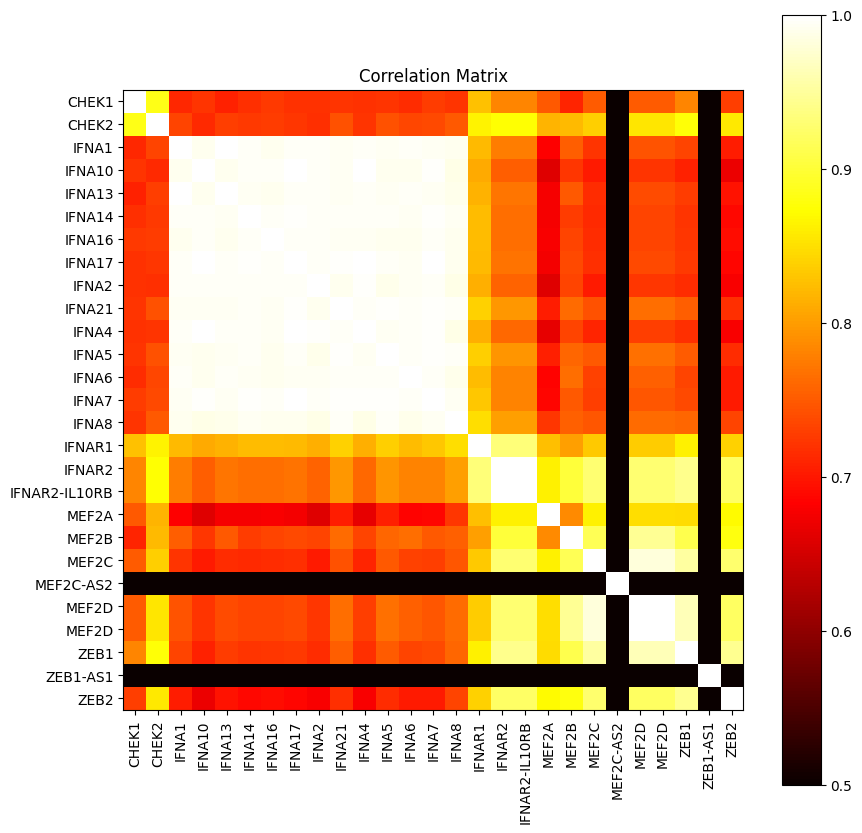

In [62]:
import matplotlib.pyplot as plt

correlation_matrix = np.corrcoef(adata[loc['ensembl_gene_id']].X)
plt.figure(figsize=(10,10))
plt.imshow(correlation_matrix, cmap='hot', interpolation='nearest', vmin=0.5)
plt.colorbar()
plt.xticks(ticks=np.arange(len(loc['symbol'])), labels=loc['symbol'], rotation=90)
plt.yticks(ticks=np.arange(len(loc['symbol'])), labels=loc['symbol'])
plt.title('Correlation Matrix')
plt.show()


In [ ]:
MEF2s
ZEB1, ZEB2
IFN1
IFN2


In [7]:
sc.tl.umap(adata)

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


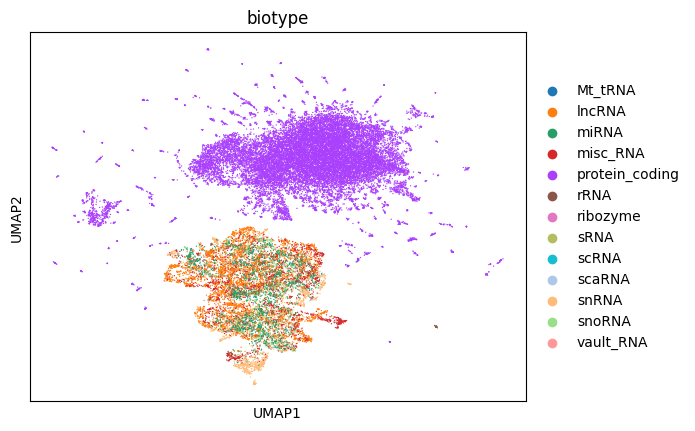

In [9]:
sc.pl.umap(adata, color=['biotype'])

In [ ]:
# make a GRN prediction task
# test on my benGRN

In [ ]:
# switch to using the new laminDB mappedCollection

In [ ]:
# follow the path of the data through the model and the transformers
# follow the loss computations
# follow what happens to the uncalled functions of optimizations etc.. how the lr gets updated (it never gets updated on my end)
# follow what happens to the gradients scaling (weight) and some other values

# test DAB loss

# test with regular transformer and make it work with current weights

# look at why we can't visualize the model graph


In [ ]:
# look at why we can't see the parameters in wandb?
# look at plotting the params of the dataloader too

# impact of gradient clipping
# what happens when distributed random sampling in case of ddp??
# find a way to relaunch job after a slurm sigterm

In [ ]:
# import scGPT's weights

In [8]:
model = scPrint(
    genes = datamodule.genes,
    d_model = d_model,
    nhead = 4,
    nlayers = 4,
    layers_cls = [],
    labels = datamodule.labels,
    cls_hierarchy = datamodule.cls_hierarchy,
    dropout= 0.1,
    transformer = "flash",
    precpt_gene_emb = gene_emb,
    gene_pos_enc = datamodule.gene_pos,
    mvc_decoder = "inner product",
    label_decoders = datamodule.decoders,
    fused_dropout_add_ln = False
)

scPrint(
  (gene_encoder): GeneEncoder(
    (embedding): Embedding(33890, 256)
    (enc_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (expr_encoder): ContinuousValueEncoder(
    (encoder): ModuleList(
      (0): Linear(in_features=1, out_features=256, bias=True)
      (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
      (3): Dropout(p=0.1, inplace=False)
    )
  )
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (label_encoder): CategoryValueEncoder(
    (embedding): Embedding(8, 256)
    (enc_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (depth_decoder): ContinuousValueEncoder(
    (encoder): ModuleList(
      (0): Linear(in_features=1, out_features=256, bias=True)
      (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
      (3): Dropout(p=0.1, inplace=False)
    )
  )
  (transformer): FlashTransformerEn

In [ ]:
# create a function to transform an scGPT checkpoint to an scPrint's
# ckpt = torch.load("../../scGPT/save/model_e6.pt")
# scPrint.load_from_checkpoint("../../scGPT/save/model_e6.pt")

In [ ]:
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.loggers import WandbLogger

wandb_logger = WandbLogger(project="scprint_test", save_dir="../data/tensorboard")
wandb_logger.watch(model, log='all', log_freq=50, log_graph=True)

#tlogger = TensorBoardLogger(save_dir="../data/tensorboard")
#tlogger.log_graph(model, i)


2024-02-19 16:41:43,615:ERROR - Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jkobject (ml4ig). Use `wandb login --relogin` to force relogin


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [ ]:
#from lightning.pytorch.profilers import PyTorchProfiler
#pytorch_prof = PyTorchProfiler("../data/tensorboard", emit_nvtx=False, group_by_input_shape=True, record_shapes=True, profile_memory=True, with_stack=True, on_trace_ready=torch.profiler.tensorboard_trace_handler("../data/tensorboard/"),)

In [14]:
chckp = ModelCheckpoint(monitor="val_loss", save_top_k=-1)
trainingmode = TrainingMode(do_denoise=True, noise=[0.3], do_cce=True, cce_sim=0.5, do_ecs=True, ecs_threshold = 0.3, ecs_scale = 10.0, do_mvc=False, do_adv_cls=False, do_next_tp=False, class_scale = 5000.0, mask_ratio=[0.15, 0.3], warmup_duration= 500, weight_decay= 0.1, fused_adam= True,lr_patience= 1)
es = EarlyStopping(patience=2, monitor='val_loss')
swa = StochasticWeightAveraging(swa_lrs= 0.01)
lrm = LearningRateMonitor(logging_interval="step")
#lrf = LearningRateFinder(mode="exponential",)
# TODO: to check that the class hierarchy are really ordered from 1-2-3-4... as well (oredered dict)
trainer = Trainer(precision="16-mixed", gradient_clip_val=10, max_time={"hours": 3}, limit_train_batches=5000, limit_test_batches=0.03, limit_val_batches=1000, callbacks=[chckp, trainingmode, es, lrm], accumulate_grad_batches=2, reload_dataloaders_every_n_epochs=1) #detect_anomaly=True, fast_dev_run=20, overfit_batches=10, limit_train_batches=1, limit_val_batches=0
#logger=wandb_logger,

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [10]:
model.lr, model.hparams.lr

(0.001, 0.001)

In [13]:
# sanity. should be overfiting.
trainer = Trainer(precision="16-mixed", max_epochs=1000, limit_val_batches=0, check_val_every_n_epoch=1000, log_every_n_steps=1000, detect_anomaly=False, overfit_batches=1,
reload_dataloaders_every_n_epochs=1000) #logger=wandb_logger) limit_train_batches=1

Using 16bit Automatic Mixed Precision (AMP)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.


In [15]:
trainer.fit(model, datamodule=datamodule)

these files will be considered test datasets:
    /home/ml4ig1/scprint/.lamindb/BljRloq1xjcxRNDpejzI.h5ad
    /home/ml4ig1/scprint/.lamindb/yBCKp6HmXuHa0cZptMo7.h5ad
perc test:  0.0057480725242011555


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                    | Params
----------------------------------------------------------
0 | gene_encoder  | GeneEncoder             | 8.7 M 
1 | expr_encoder  | ContinuousValueEncoder  | 1.0 K 
2 | pos_encoder   | PositionalEncoding      | 0     
3 | label_encoder | CategoryValueEncoder    | 2.6 K 
4 | depth_decoder | ContinuousValueEncoder  | 1.0 K 
5 | transformer   | FlashTransformerEncoder | 3.2 M 
6 | expr_decoder  | ExprDecoder             | 132 K 
7 | cls_decoders  | ModuleDict              | 58.9 K
8 | mvc_decoder   | MVCDecoder              | 262 K 
----------------------------------------------------------
3.6 M     Trainable params
8.7 M     Non-trainable params
12.3 M    Total params
49.179    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 106 × 256
    obs: 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'cell_type_ontology_term_id', 'disease_ontology_term_id', 'assay_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'organism_ontology_term_id', 'conv_cell_type_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_assay_ontology_term_id', 'conv_pred_assay_ontology_term_id', 'leiden'
    uns: 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

couldn't log to tensorboard
couldn't log to wandb


Training: 0it [00:00, ?it/s]

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir="../data/tensorboard"

In [10]:
#wandb_logger.finalize(status="aborted")
torch.cuda.empty_cache()

In [ ]:
----
# TODO: connect with maestro people to ask for longer compute time 
# TODO: do the same to jean zay (0.5 day)
------
# TODO: make a model benchmark package (continue from where I left off) (4 days)
# TODO: make a task function & make a benchmark function (1 day) (*denoising, *perturbation prediction)
------
# TODO: debug the gene embedding creation
# TODO: create embedding & make it work for the 4-5 species in the dataset (1 days) 
# TODO: find the neighboors and next time point cells (1 days)
# TODO: create a version with next time point and neighboors task (1 days)
# TODO: make a trajectory prediction task (predict future cell type/s, expression) and benchmark (similarity to known future cell, similarity to known future expression) (1 days)
------
# TODO: run a large training on maestro (0.5 day)
------
# TODO: add KO & drug datasets
# TODO: create a version with KO and drug effect prediction